In [1]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
from keras.utils import load_img
from keras.utils import img_to_array
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

physical_devices = tf.config.list_physical_devices('GPU')
# Disable first GPU
tf.config.set_visible_devices(physical_devices[1:], 'GPU')


# Data loading

In [4]:
# Function to load image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(200,200,1), color_mode="grayscale")
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 200,200,1)
    
	# convert pixel data to 0-1 data
	img = img.astype('float32')
	img /= 255.0
	return img[0]

## Target + confirming

To train the model, a CSV file containing the label (1.0 = detected/0.5 = suspicious/0.0 = not-detected) of each input (combinaison of two transitions for a target) is needed. It is required to provide in the CSV the JPEG name (sample name + "_comp=" + target name + ".jpeg") to match each input to the correct label.

"train-data" is the directory containing the training dataset, so after processing of the raw data by the Rscript. This directory is composed of all JPEG images, a PDF report for each sample and two CSV files, for transition 1 and 2, containing the analytical parameters (number of points, area, RT deviation and the JPEG filename).

In [9]:
# Load plot images in a directory and convert as array
# Generate labels according to label file
label_tab = pd.read_csv("labels_train-data.csv")

peakinfo_csv = pd.read_csv("train-data/peakinfo.csv")

dataY = []
data_target = []
data_confirming = []

peak_info = []

for i in range(0,len(peakinfo_csv)):
    file = peakinfo_csv['plotname'][i]
    file_confirming = file.replace(".jpeg", "_confirming.jpeg")
    filename = os.path.basename(file)
    # if there is a label for this file and there is a confirming peak
    if filename in label_tab['PLOTname'].tolist() and os.path.exists(file_confirming):
        peak_info.append(peakinfo_csv.iloc[i].tolist())
        
        # Load input 
        data_target.append(load_image(file))
        data_confirming.append(load_image(file_confirming))
            
        # Index where label equal to current file
        idx = np.flatnonzero(label_tab['PLOTname'] == filename)[0]
        # Get label
        dataY.append([file, label_tab['vu'][idx]])

data_target = np.array(data_target)
data_confirming = np.array(data_confirming)
dataY = pd.DataFrame(dataY)

# Format peak information
peak_info = pd.DataFrame(peak_info)
peak_info.columns = ['plotname', 'area', 'points', 'devRRT']
peak_info['log_area'] = [np.log10(area) if area > 0 else area for area in peak_info['area']]

print(data_target.shape)

(3964, 200, 200, 1)


# Model creation and training

In [15]:
# Split train and test datasets 
from sklearn.model_selection import train_test_split
X_train_target, X_test_target, X_train_confirming, X_test_confirming, X_train_peak_info, X_test_peak_info, y_train, y_test = train_test_split(data_target, data_confirming, peak_info,
                                                                                                     dataY, test_size=0.3, random_state=22)


## Cross validation to find the best parameters

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD
# Define the neural network
def define_model(param):
	input_target = Input(shape=(200,200,1))
	input_confirming = Input(shape=(200,200,1))
    
    # Convolution to synthetise the information of the target chromatogram 
	x = Conv2D(32, 3, activation='relu')(input_target)
	x = MaxPooling2D(2)(x)
	x = Conv2D(64, 3, activation='relu')(x)    
	x = MaxPooling2D(2)(x)
	# Transform matrix to a flat vector
	x = Flatten()(x)    
	x = Dense(128, activation='relu')(x)
	x = Dense(64, activation='relu')(x)
	x = Dense(32, activation='relu')(x)
	x = Model(inputs=input_target, outputs=x)
    
    # Convolution to synthetise the information of the confirming chromatogram 
	y = Conv2D(32, 3, activation='relu')(input_confirming)
	y = MaxPooling2D(2)(y)
	y = Conv2D(64, 3, activation='relu')(y)    
	y = MaxPooling2D(2)(y)
	# Transform matrix to a flat vector
	y = Flatten()(y)    
	y = Dense(128, activation='relu')(y)
	y = Dense(64, activation='relu')(y)
	y = Dropout(param['dropout'])(y)
	y = Dense(32, activation='relu')(y)
	y = Dropout(param['dropout'])(y)
	y = Model(inputs=input_confirming, outputs=y)
    
    
    # Combine the output of the two branches
	combined = concatenate([x.output, y.output])

    # apply a FC layer and then a regression prediction on the
    # combined outputs
	z = Dense(64)(combined)
	z = Dense(32)(z)
	z = Dense(16)(z)
	z = Dense(8)(z)
	z = Dense(4)(z)
	z = Dense(1)(z)

    # our model will accept the inputs of the two branches and
    # then output a single value
	model = Model(inputs=[x.input, y.input], outputs=z)
    
	# compile model
	model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
	return model

#mod.summary()

In [ ]:
from kerashypetune import KerasGridSearchCV
from sklearn.model_selection import KFold

param_grid = {
    #'opt' : ['rmsprop', 'adam'], 
    #'act': ["softmax", "linear", "relu", "sigmoid"],
    'dropout': [0,0.2,0.3],
    #'loss': ['mse', 'mae'],
    'epochs': 10,
    #'lr': [1e-2,1e-3], 
    #'batch_size': [10, 20, 40, 64]
}

cv = KFold(n_splits=3, random_state=33, shuffle=True)

kgs = KerasGridSearchCV(define_model, param_grid, cv=cv, tuner_verbose=1,
                        monitor='val_accuracy', greater_is_better=True)
kgs.search([X_train_target, X_train_confirming], np.array(y_train[1]))

## Train model

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD
# Define the neural network
def define_model():
	input_target = Input(shape=(200,200,1))
	input_confirming = Input(shape=(200,200,1))
    
    # Convolution to synthetise the information of the target chromatogram 
	x = Conv2D(32, 3, activation='relu')(input_target)
	x = MaxPooling2D(2)(x)
	x = Conv2D(64, 3, activation='relu')(x)    
	x = MaxPooling2D(2)(x)
	# Transform matrix to a flat vector
	x = Flatten()(x)    
	x = Dense(128, activation='relu')(x)
	x = Dense(64, activation='relu')(x)
	x = Dense(32, activation='relu')(x)
	x = Model(inputs=input_target, outputs=x)
    
    # Convolution to synthetise the information of the confirming chromatogram 
	y = Conv2D(32, 3, activation='relu')(input_confirming)
	y = MaxPooling2D(2)(y)
	y = Conv2D(64, 3, activation='relu')(y)    
	y = MaxPooling2D(2)(y)
	# Transform matrix to a flat vector
	y = Flatten()(y)    
	y = Dense(128, activation='relu')(y)
	y = Dense(64, activation='relu')(y)
	y = Dropout(0.2)(y)
	y = Dense(32, activation='relu')(y)
	y = Dropout(0.2)(y)
	y = Model(inputs=input_confirming, outputs=y)
    
    # Combine the output of the two branches
	combined = concatenate([x.output, y.output])

	z = Dense(64)(combined)
	z = Dense(32)(z)
	z = Dense(16)(z)
	z = Dense(8)(z)
	z = Dense(4)(z)
	z = Dense(1)(z)

    # The model will accept the inputs of the two branches and
    # then output a single value
	model = Model(inputs=[x.input, y.input], outputs=z)
    
	# Compile model
	model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
	return model

mod_CNN = define_model()
#mod.summary()

In [15]:
history = mod_CNN.fit([X_train_target, X_train_confirming], y_train[1], epochs=10, batch_size=64, validation_split=.2)

Epoch 1/10


/usr/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_25', 'keras_tensor_26']. Received: the structure of inputs=('*', '*')
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 397ms/step - accuracy: 0.4757 - loss: 239.6327 - val_accuracy: 0.6847 - val_loss: 0.1789
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 382ms/step - accuracy: 0.7173 - loss: 0.1707 - val_accuracy: 0.9099 - val_loss: 0.0531
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 384ms/step - accuracy: 0.9273 - loss: 0.0481 - val_accuracy: 0.9351 - val_loss: 0.0292
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.9355 - loss: 0.0318 - val_accuracy: 0.9441 - val_loss: 0.0277
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 377ms/step - accuracy: 0.9339 - loss: 0.0297 - val_accuracy: 0.9441 - val_loss: 0.0257
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 376ms/step - accuracy: 0.9365 - loss: 0.0290 - val_accuracy: 0.9495 - val_loss: 0.0222
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 377ms/step - accuracy: 0.9467 - loss: 0.0236 - val_accuracy: 0.9459 - val_loss: 0.0195
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.9424 - loss: 0.0243 - val_accuracy: 0.9

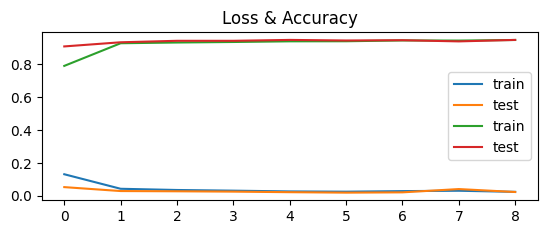

In [16]:
# Plot loss during training
plt.subplot(211)
plt.title('Loss & Accuracy')
plt.plot(history.history['loss'][1:], label='train')
plt.plot(history.history['val_loss'][1:], label='test')
plt.legend()
# Plot accuracy during training
plt.plot(history.history['accuracy'][1:], label='train')
plt.plot(history.history['val_accuracy'][1:], label='test')
plt.legend()
plt.show()

In [16]:
test_loss, test_acc = mod_CNN.evaluate([X_test_target, X_test_confirming],  y_test[1], verbose=2)

38/38 - 1s - loss: 0.0247 - accuracy: 0.9529 - 708ms/epoch - 19ms/step


## Save/Load model

In [51]:
# Save model
#mod_CNN.save("Models/CNN_trained_model.h5")

In [13]:
import keras
mod_CNN = keras.models.load_model("Models/CNN_trained_model.h5")

2024-10-31 07:46:40.410765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-31 07:46:41.367099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6650 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:af:00.0, compute capability: 7.5


## LDA

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [18]:
predictions = mod_CNN.predict([X_test_target, X_test_confirming]).round(2)

38/38 [==============================] - 1s 13ms/step


In [20]:
input_lda = X_test_peak_info
input_lda['Predictions'] = predictions

In [21]:
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(input_lda, y_test, test_size=0.2, random_state=19)

In [22]:
print(X_train_lda.shape)
print(y_train_lda.shape)

(952, 6)
(952, 2)


In [23]:
y_train_lda_cat = y_train_lda[1].astype('string')
y_test_lda_cat = y_test_lda[1].astype('string')

In [24]:
from numpy import mean
from numpy import std

# Define model
model = LinearDiscriminantAnalysis()
# Define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
# Evaluate model
scores = cross_val_score(model, input_lda[['log_area', 'points', 'devRRT', 'Predictions']], y_test[1].astype('string'), scoring='accuracy', cv=cv, n_jobs=-1)
# Summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.942 (0.011)


In [25]:
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train_lda[['log_area', 'points', 'devRRT', 'Predictions']], y_train_lda_cat)

LinearDiscriminantAnalysis()

In [26]:
model_lda.coef_

array([[ -5.68319921,   0.31852543, -19.85246275, -29.15849   ],
       [ -5.54276363,   0.3071368 , -21.24849128, -15.96830743],
       [  2.96693362,  -0.16612407,  10.45158423,  14.6436975 ]])

In [27]:
pred_lda = model_lda.predict(X_test_lda[['log_area', 'points', 'devRRT', 'Predictions']])

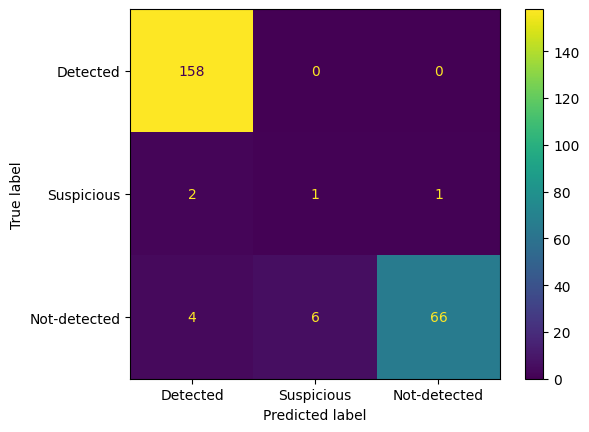

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat_lda = confusion_matrix(y_test_lda_cat, pred_lda, labels=["1.0","0.5","0.0"])
disp_lda = ConfusionMatrixDisplay(conf_mat_lda, display_labels=["Detected","Suspicious","Not-detected"])
disp_lda.plot()

In [30]:
pred_lda_proba = model_lda.predict_proba(X_test_lda[['log_area', 'points', 'devRRT', 'Predictions']])

In [31]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(np.array(y_train_lda_cat))
y_onehot_test = label_binarizer.transform(y_test_lda_cat)
y_onehot_test.shape  # (n_samples, n_classes)

(238, 3)

In [32]:
target_names = ["Not-detected", "Suspicious", "Detected"]
line = ['solid', 'dotted', 'dashed']
color = ["#002A7E", "#FF6600", "#3377FF"]

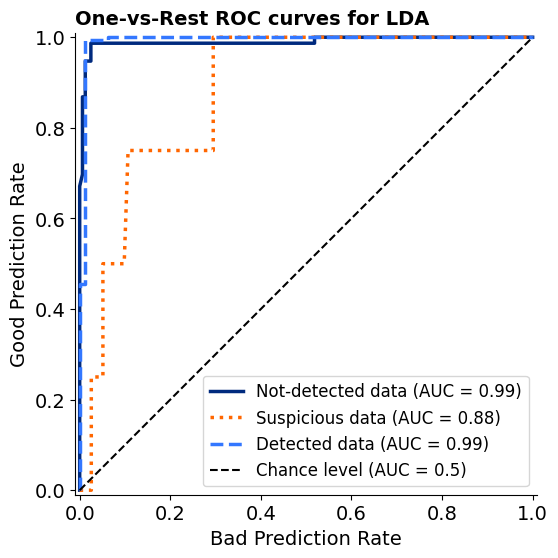

In [34]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))
for class_id in [0,1,2]:
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        pred_lda_proba[:, class_id],
        name=f"{target_names[class_id]} data",
        linestyle = line[class_id],
        ax=ax, color=color[class_id],
        plot_chance_level=(class_id == 2),
        linewidth = 2.5,
    )

# Show only X and Y axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Bad Prediction Rate", fontsize=14)
plt.ylabel("Good Prediction Rate", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.title("One-vs-Rest ROC curves for LDA", fontweight="bold", loc="left", fontsize=14)
legend = plt.legend(fontsize=12)


In [ ]:
## save model LDA
#import joblib
#joblib.dump(model_lda, 'Models/LDA_trained_model.pkl')